<p style="font-size: 30px; text-align:center; font-weight:bold"> Data visualization from UIS data </p>

<center>
        <img style="display: inline-block; margin-right: 75px; width: 150px" src="pictures/UIS_logo.jpg">
        <img style="width: 150px; display: inline-block;" src="pictures/SDG_logo.png">
</center>

From February 7 to 9, 2024, the UNESCO Institute for Statistics ([UIS](https://uis.unesco.org/)) held its first [Conference on Education Data and Statistics](https://ces.uis.unesco.org/) in Paris. During the conference, discussions were held on the various aspects of Sustainable Development Goals indicators 4 ([SDG 4](https://sdgs.un.org/goals/goal4)). These indicators concern different aspects of education, and their descriptions are available [here](https://www.education-progress.org/en/indicators). Thanks to the SDG 4 data available at the following link: http://sdg4-data.uis.unesco.org/, we have produced three representations highlighting the importance of these indicators for a better understanding of education issues in our world.
- **The completion rate for every level of education**
- **The proficiency in reading in function of government expenditure in education**
- **Primary schools with access to electricity**

In the notebook that follows, we show the Python code that enabled us to obtain these representations.

In [1]:
import pandas as pd
import numpy as np
import datapackage
from datapackage import Package
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import country_converter as coco
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import LinearRegression
from adjustText import adjust_text
import matplotlib as mpl
from matplotlib.patheffects import withStroke
from matplotlib import lines
from matplotlib import patches
from matplotlib.font_manager import FontProperties
from matplotlib.colors import ListedColormap
from matplotlib import font_manager
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Completion rate for every level of education

## Import data and create the dataframes

### Completion data

In [2]:
completion_rate_data = pd.read_csv("data/global_completion.csv")

In [3]:
completion_rate_data

,Region,Country,Target,Indicator Number,Indicator Name,Year,Value,Metadata
0,SDG: Central and Southern Asia,Afghanistan,4.1,4.1.2,"Completion rate, primary education, both sexes...",2018,61.40,SOURCE: https://education-estimates.org/comple...
1,SDG: Central and Southern Asia,Afghanistan,4.1,4.1.2,"Completion rate, primary education, both sexes...",2022,44.24,SOURCE: Afghanistan MICS 2022-23. The survey c...
2,SDG: Central and Southern Asia,Afghanistan,4.1,4.1.2,"Completion rate, lower secondary education, bo...",2018,46.00,SOURCE: https://education-estimates.org/comple...
3,SDG: Central and Southern Asia,Afghanistan,4.1,4.1.2,"Completion rate, lower secondary education, bo...",2022,31.27,SOURCE: Afghanistan MICS 2022-23. The survey c...
4,SDG: Central and Southern Asia,Afghanistan,4.1,4.1.2,"Completion rate, primary education, both sexes...",2020,65.20,SOURCE: https://education-estimates.org/comple...
...,...,...,...,...,...,...,...,...
1280,SDG: Sub-Saharan Africa,Zimbabwe,4.1,4.1.2,"Completion rate, upper secondary education, bo...",2018,7.70,SOURCE: https://education-estimates.org/comple...
1281,SDG: Sub-Saharan Africa,Zimbabwe,4.1,4.1.2,"Completion rate, lower secondary education, bo...",2018,71.60,SOURCE: https://education-estimates.org/comple...
1282,SDG: Sub-Saharan Africa,Zimbabwe,4.1,4.1.2,"Completion rate, upper secondary education, bo...",2020,7.60,SOURCE: https://education-estimates.org/comple...
1283,SDG: Sub-Saharan Africa,Zimbabwe,4.1,4.1.2,"Completion rate, primary education, both sexes...",2018,86.20,SOURCE: https://education-estimates.org/comple...


We select the indicators to create three new dataframes for each one of them.

In [4]:
indicators = list(pd.unique(completion_rate_data["Indicator Name"]))

In [5]:
print(indicators)

['Completion rate, primary education, both sexes (%)', 'Completion rate, lower secondary education, both sexes (%)', 'Completion rate, upper secondary education, both sexes (%)']


For the three folowing dataframes that we'll create, we use the [`country_converter`](https://github.com/IndEcol/country_converter) package to add an `id` column with the [ISO3](https://en.wikipedia.org/wiki/ISO_3166-1) code of every country. With that, we'll be able to merge our dataframes with geospatial data.

To have a more complete final dataframe, we keep only the last record between 2018 and 2023 for every contry. That allow us to have comparable data between countries.

Now, we create our three dataframes.

#### Primary education

In [6]:
completion_pe = completion_rate_data[completion_rate_data["Indicator Name"]==indicators[0]]

new_completion_pe = pd.DataFrame()
for country in pd.unique(completion_pe["Country"]) :
    # Selecting the year of the last record
    last_year = max(list(completion_pe[completion_pe["Country"]==country]["Year"]))
    # Add the row of the last record to the new dataframe
    new_completion_pe = pd.concat([new_completion_pe, completion_pe[(completion_pe["Country"]==country)&(completion_pe["Year"]==last_year)]])

# Add an 'id' column with the ISO3 code of the country
new_completion_pe["id"] = coco.convert(names=list(new_completion_pe["Country"]), to='ISO3')

#### Lower secondary

In [7]:
completion_lse = completion_rate_data[completion_rate_data["Indicator Name"]==indicators[1]]

new_completion_lse = pd.DataFrame()
for country in pd.unique(completion_lse["Country"]) :
    # Selecting the year of the last record
    last_year = max(list(completion_lse[completion_lse["Country"]==country]["Year"]))
    # Add the row of the last record to the new dataframe
    new_completion_lse = pd.concat([new_completion_lse, completion_lse[(completion_lse["Country"]==country)&(completion_lse["Year"]==last_year)]])

# Add an 'id' column with the ISO3 code of the country
new_completion_lse["id"] = coco.convert(names=list(new_completion_lse["Country"]), to='ISO3')

#### Upper secondary

In [8]:
completion_use = completion_rate_data[completion_rate_data["Indicator Name"]==indicators[2]]

new_completion_use = pd.DataFrame()
for country in pd.unique(completion_use["Country"]) :
    # Selecting the year of the last record
    last_year = max(list(completion_use[completion_use["Country"]==country]["Year"]))
    # Add the row of the last record to the new dataframe
    new_completion_use = pd.concat([new_completion_use, completion_use[(completion_use["Country"]==country)&(completion_use["Year"]==last_year)]])

# Add an 'id' column with the ISO3 code of the country
new_completion_use["id"] = coco.convert(names=list(new_completion_use["Country"]), to='ISO3')

### Geospatial data

We now add geospatial data to the three dataframes we've created above. To achieve that, we use the [`geoplot`](https://residentmario.github.io/geoplot/) package wich contain a `datasets` function to import geospatial data.

#### Primary education

In [9]:
world_data_pe = gpd.read_file(geoplot.datasets.get_path('world'))
# Merge the world data with the UIS datas
world_data_pe = pd.merge(world_data_pe, new_completion_pe, on="id", how="outer")
# Keep useful datas
world_data_pe = world_data_pe[world_data_pe["geometry"]!=None]
# Repalce NA values by 0 in the "Value" column
world_data_pe["Value"] = world_data_pe["Value"].fillna(0)
# Remove Antarctica
world_data_pe = world_data_pe[world_data_pe["name"]!="Antarctica"]

#### Lower secondary education

In [10]:
world_data_lse = gpd.read_file(geoplot.datasets.get_path('world'))
# Merge the world data with the UIS datas
world_data_lse = pd.merge(world_data_lse, new_completion_lse, on="id", how="outer")
# Keep useful datas
world_data_lse = world_data_lse[world_data_lse["geometry"]!=None]
# Repalce NA values by 0 in the "Value" column
world_data_lse["Value"] = world_data_lse["Value"].fillna(0)
# Remove Antarctica
world_data_lse = world_data_lse[world_data_lse["name"]!="Antarctica"]

#### Upper secondary data

In [11]:
world_data_use = gpd.read_file(geoplot.datasets.get_path('world'))
# Merge the world data with the UIS datas
world_data_use = pd.merge(world_data_use, new_completion_use, on="id", how="outer")
# Keep useful datas
world_data_use = world_data_use[world_data_use["geometry"]!=None]
# Repalce NA values by 0 in the "Value" column
world_data_use["Value"] = world_data_use["Value"].fillna(0)
# Remove Antarctica
world_data_use = world_data_use[world_data_use["name"]!="Antarctica"]

## Create the representation

### Create the colormap for the maps

We create a colormap for the three maps that we'll dispaly. The particularity of our colormap is that the value `0` corresponds to the gray color. This color will correspond to the countries with no data available.

In [12]:
cmap = plt.cm.Blues 
cmap_list = [cmap(i) for i in range(cmap.N)]
cmap_list[0] = (0.8, 0.8, 0.8, 1.0)
custom_cmap = ListedColormap(cmap_list)

### Plot the representation

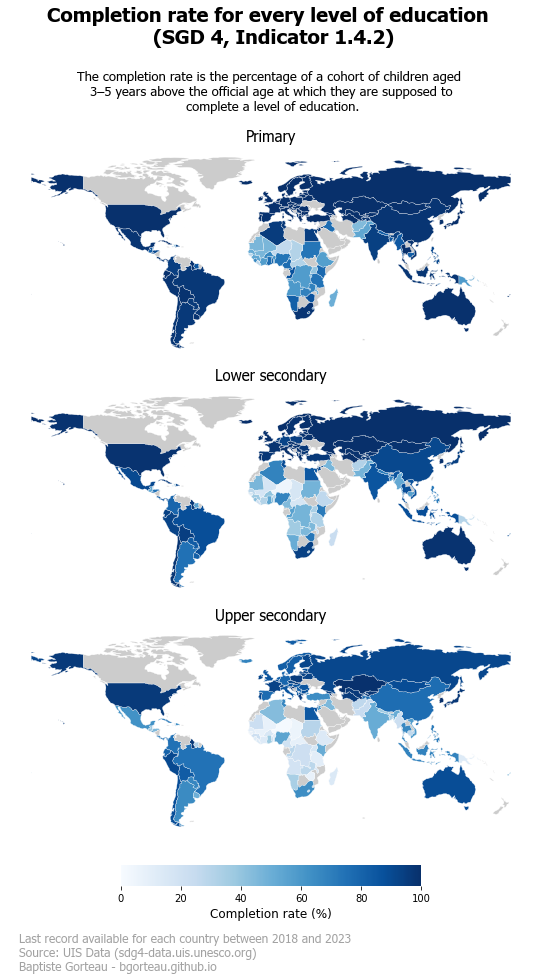

In [13]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [1, 1, 1, 0.1]})

######################################################

# Draw the first representation on the first sub-graph
world_data_pe.plot(ax=axs[0], edgecolor="white", column='Value', cmap=custom_cmap, linewidth=0.3)
axs[0].set_title("Primary", size=15, fontfamily="Tahoma")
axs[0].axis('off')

######################################################

# Draw the second representation on the second sub-graph
world_data_lse.plot(ax=axs[1], edgecolor="white", column='Value', cmap=custom_cmap, linewidth=0.3)
axs[1].set_title("Lower secondary", size=15, fontfamily="Tahoma")
axs[1].axis('off')

######################################################

# Draw the third representation on the second sub-graph
world_data_use.plot(ax=axs[2], edgecolor="white", column='Value', cmap=custom_cmap, linewidth=0.3)
axs[2].set_title("Upper secondary", size=15, fontfamily="Tahoma")
axs[2].axis('off')

######################################################

# Plot the colorbar
cmap = plt.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=100)

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=axs[3], orientation='horizontal', label='Completion rate (%)')

cbar.ax.set_aspect(7)

cbar.ax.set_frame_on(False)
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.xaxis.label.set_size(12)

######################################################

# Adding new elements to the representation

fig.suptitle("Completion rate for every level of education \n (SGD 4, Indicator 1.4.2)", size=20, y=1.07, fontweight="semibold", fontfamily="Tahoma")

fig.text(0.5, 0.95, "The completion rate is the percentage of a cohort of children aged \n 3–5 years above the official age at which they are supposed to \n complete a level of education.", ha='center', fontsize=13, fontfamily="Tahoma") 
fig.text(0.15, -0.045, "Last record available for each country between 2018 and 2023 \nSource: UIS Data (sdg4-data.uis.unesco.org) \nBaptiste Gorteau - bgorteau.github.io", ha='left', fontsize=12, fontfamily="Tahoma", color="#a2a2a2") 
fig.set_facecolor("white")
plt.tight_layout()

######################################################

fig.savefig("figures/completion_rate.png", dpi=300, bbox_inches='tight', pad_inches=0.5)

# Proficiency in reading at primary in function of government expenditure in education

## Import and create the dataframes

Like for the representation before, we add an `id` column with the ISO3 code and we keep the last record between 2018 and 2023 for each country.

### Proficiency in reading at primary

In [14]:
reading_primary_data = pd.read_csv("data/reading_primary.csv")

In [15]:
reading_primary_data

,Region,Country,Target,Indicator Number,Indicator Name,Year,Value,Metadata
0,SDG: Europe and Northern America,Albania,4.1,4.1.1,Proportion of students at the end of primary e...,2021,92.12,SOURCE: Progress in International Reading Lite...
1,SDG: Northern Africa and Western Asia,United Arab Emirates,4.1,4.1.1,Proportion of students at the end of primary e...,2021,75.03,SOURCE: Progress in International Reading Lite...
2,SDG: Latin America and the Caribbean,Argentina,4.1,4.1.1,Proportion of students at the end of primary e...,2019,31.90,SOURCE: Laboratorio Latinoamericano de Evaluac...
3,SDG: Europe and Northern America,Austria,4.1,4.1.1,Proportion of students at the end of primary e...,2021,95.92,SOURCE: Progress in International Reading Lite...
4,SDG: Northern Africa and Western Asia,Azerbaijan,4.1,4.1.1,Proportion of students at the end of primary e...,2021,67.43,SOURCE: Progress in International Reading Lite...
...,...,...,...,...,...,...,...,...
83,SDG: Europe and Northern America,United States of America,4.1,4.1.1,Proportion of students at the end of primary e...,2021,94.51,SOURCE: Progress in International Reading Lite...
84,SDG: Central and Southern Asia,Uzbekistan,4.1,4.1.1,Proportion of students at the end of primary e...,2021,69.84,SOURCE: Progress in International Reading Lite...
85,SDG: Central Asia,Uzbekistan,4.1,4.1.1,Proportion of students at the end of primary e...,2021,69.84,SOURCE: Progress in International Reading Lite...
86,SDG: Eastern and South-Eastern Asia,Viet Nam,4.1,4.1.1,Proportion of students at the end of primary e...,2019,82.00,SOURCE: Southeast Asia Primary Learning Metric...


In [16]:
new_reading_primary_data = pd.DataFrame()

for country in pd.unique(reading_primary_data["Country"]) :
    # Selecting the year of the last record
    last_year = max(list(reading_primary_data[reading_primary_data["Country"]==country]["Year"]))
    # Add the row of the last record to the new dataframe
    new_reading_primary_data = pd.concat([new_reading_primary_data, reading_primary_data[(reading_primary_data["Country"]==country)&(reading_primary_data["Year"]==last_year)]])
    
# Add an 'id' column with the ISO3 code of the country
new_reading_primary_data["id"] = coco.convert(names=list(new_reading_primary_data["Country"]), to='ISO3')

In [17]:
new_reading_primary_data

,Region,Country,Target,Indicator Number,Indicator Name,Year,Value,Metadata,id
0,SDG: Europe and Northern America,Albania,4.1,4.1.1,Proportion of students at the end of primary e...,2021,92.12,SOURCE: Progress in International Reading Lite...,ALB
1,SDG: Northern Africa and Western Asia,United Arab Emirates,4.1,4.1.1,Proportion of students at the end of primary e...,2021,75.03,SOURCE: Progress in International Reading Lite...,ARE
2,SDG: Latin America and the Caribbean,Argentina,4.1,4.1.1,Proportion of students at the end of primary e...,2019,31.90,SOURCE: Laboratorio Latinoamericano de Evaluac...,ARG
3,SDG: Europe and Northern America,Austria,4.1,4.1.1,Proportion of students at the end of primary e...,2021,95.92,SOURCE: Progress in International Reading Lite...,AUT
4,SDG: Northern Africa and Western Asia,Azerbaijan,4.1,4.1.1,Proportion of students at the end of primary e...,2021,67.43,SOURCE: Progress in International Reading Lite...,AZE
...,...,...,...,...,...,...,...,...,...
83,SDG: Europe and Northern America,United States of America,4.1,4.1.1,Proportion of students at the end of primary e...,2021,94.51,SOURCE: Progress in International Reading Lite...,USA
84,SDG: Central and Southern Asia,Uzbekistan,4.1,4.1.1,Proportion of students at the end of primary e...,2021,69.84,SOURCE: Progress in International Reading Lite...,UZB
85,SDG: Central Asia,Uzbekistan,4.1,4.1.1,Proportion of students at the end of primary e...,2021,69.84,SOURCE: Progress in International Reading Lite...,UZB
86,SDG: Eastern and South-Eastern Asia,Viet Nam,4.1,4.1.1,Proportion of students at the end of primary e...,2019,82.00,SOURCE: Southeast Asia Primary Learning Metric...,VNM


### Government expenditures in education

In [18]:
government_expenditures = pd.read_csv("data/gov_expenditures.csv")

In [19]:
government_expenditures

,Region,Country,Target,Indicator Number,Indicator Name,Year,Value,Metadata
0,SDG: Sub-Saharan Africa,Angola,1.a,1.a.2,Expenditure on education as a percentage of to...,2018,5.41,SOURCE: ORCAMENTO GERAL DO ESTADO | 2018 (htt...
1,SDG: Sub-Saharan Africa,Angola,1.a,1.a.2,Expenditure on education as a percentage of to...,2021,6.92,SOURCE: ORCAMENTO GERAL DO ESTADO | 2021 (htt...
2,SDG: Sub-Saharan Africa,Angola,1.a,1.a.2,Expenditure on education as a percentage of to...,2020,6.47,SOURCE: ORCAMENTO GERAL DO ESTADO | 2020 (htt...
3,SDG: Sub-Saharan Africa,Angola,1.a,1.a.2,Expenditure on education as a percentage of to...,2019,6.05,SOURCE: ORCAMENTO GERAL DO ESTADO | 2019 (htt...
4,SDG: Sub-Saharan Africa,Angola,1.a,1.a.2,Expenditure on education as a percentage of to...,2022,6.64,SOURCE: ORCAMENTO GERAL DO ESTADO | 2022 (htt...
...,...,...,...,...,...,...,...,...
756,SDG: Sub-Saharan Africa,Zambia,1.a,1.a.2,Expenditure on education as a percentage of to...,2019,15.29,SOURCE: 2019 Budget Speech (https://www.parli...
757,SDG: Sub-Saharan Africa,Zambia,1.a,1.a.2,Expenditure on education as a percentage of to...,2020,12.38,SOURCE: 2020 Budget Speech (https://www.parli...
758,SDG: Sub-Saharan Africa,Zambia,1.a,1.a.2,Expenditure on education as a percentage of to...,2023,13.86,SOURCE: 2023 Budget Speech (https://www.parli...
759,SDG: Sub-Saharan Africa,Zimbabwe,1.a,1.a.2,Expenditure on education as a percentage of to...,2018,19.04,QUALIFIER: This data point is an ESTIMATE prod...


In [20]:
new_government_expenditures = pd.DataFrame()

for country in pd.unique(government_expenditures["Country"]) :
    # Selecting the year of the last record
    last_year = max(list(government_expenditures[government_expenditures["Country"]==country]["Year"]))
    # Add the row of the last record to the new dataframe
    new_government_expenditures = pd.concat([new_government_expenditures, government_expenditures[(government_expenditures["Country"]==country)&(government_expenditures["Year"]==last_year)]])

# Add an 'id' column with the ISO3 code of the country
new_government_expenditures["id"] = coco.convert(names=list(new_government_expenditures["Country"]), to='ISO3')

In [21]:
new_government_expenditures

,Region,Country,Target,Indicator Number,Indicator Name,Year,Value,Metadata,id
5,SDG: Sub-Saharan Africa,Angola,1.a,1.a.2,Expenditure on education as a percentage of to...,2023,7.73,SOURCE: ORCAMENTO GERAL DO ESTADO | 2023 (htt...,AGO
6,SDG: Latin America and the Caribbean,Anguilla,1.a,1.a.2,Expenditure on education as a percentage of to...,2022,11.79,"SOURCE: Estimates of Recurrent Revenue, Expen...",AIA
14,SDG: Europe and Northern America,Albania,1.a,1.a.2,Expenditure on education as a percentage of to...,2021,9.83,SOURCE: IMF; indicator GEETO_G14_PT: COFOG Fun...,ALB
15,SDG: Europe and Northern America,Andorra,1.a,1.a.2,Expenditure on education as a percentage of to...,2022,6.61,NaN,AND
20,SDG: Northern Africa and Western Asia,United Arab Emirates,1.a,1.a.2,Expenditure on education as a percentage of to...,2021,14.76,NaN,ARE
...,...,...,...,...,...,...,...,...,...
746,SDG: Oceania,Vanuatu,1.a,1.a.2,Expenditure on education as a percentage of to...,2020,5.01,NaN,VUT
749,SDG: Oceania,Samoa,1.a,1.a.2,Expenditure on education as a percentage of to...,2020,16.21,SOURCE: Government Finance Statistics (https:...,WSM
752,SDG: Sub-Saharan Africa,South Africa,1.a,1.a.2,Expenditure on education as a percentage of to...,2021,18.49,SOURCE: IMF; indicator GEETO_G14_PT: COFOG Fun...,ZAF
758,SDG: Sub-Saharan Africa,Zambia,1.a,1.a.2,Expenditure on education as a percentage of to...,2023,13.86,SOURCE: 2023 Budget Speech (https://www.parli...,ZMB


### Merge the two dataframes

We now merge the two dataframes created above on the `id` column. We also rename the two `Value` columns for a better usage.

In [22]:
reading_expenditures_data = pd.merge(new_reading_primary_data, new_government_expenditures[["Value", "id"]], on="id", how="outer")
reading_expenditures_data = reading_expenditures_data.dropna(subset=["Value_y"])
reading_expenditures_data = reading_expenditures_data.dropna(subset=["Country"])
reading_expenditures_data = reading_expenditures_data.rename(columns={"Value_x": "Reading_Primary", "Value_y": "Governement_Expenditures"})

In [23]:
reading_expenditures_data

,Region,Country,Target,Indicator Number,Indicator Name,Year,Reading_Primary,Metadata,id,Governement_Expenditures
0,SDG: Europe and Northern America,Albania,4.1,4.1.1,Proportion of students at the end of primary e...,2021.0,92.12,SOURCE: Progress in International Reading Lite...,ALB,9.83
1,SDG: Northern Africa and Western Asia,United Arab Emirates,4.1,4.1.1,Proportion of students at the end of primary e...,2021.0,75.03,SOURCE: Progress in International Reading Lite...,ARE,14.76
2,SDG: Latin America and the Caribbean,Argentina,4.1,4.1.1,Proportion of students at the end of primary e...,2019.0,31.90,SOURCE: Laboratorio Latinoamericano de Evaluac...,ARG,12.28
3,SDG: Europe and Northern America,Austria,4.1,4.1.1,Proportion of students at the end of primary e...,2021.0,95.92,SOURCE: Progress in International Reading Lite...,AUT,8.85
4,SDG: Northern Africa and Western Asia,Azerbaijan,4.1,4.1.1,Proportion of students at the end of primary e...,2021.0,67.43,SOURCE: Progress in International Reading Lite...,AZE,10.79
...,...,...,...,...,...,...,...,...,...,...
87,SDG: Central and Southern Asia,Uzbekistan,4.1,4.1.1,Proportion of students at the end of primary e...,2021.0,69.84,SOURCE: Progress in International Reading Lite...,UZB,21.43
88,SDG: Central Asia,Uzbekistan,4.1,4.1.1,Proportion of students at the end of primary e...,2021.0,69.84,SOURCE: Progress in International Reading Lite...,UZB,21.43
89,SDG: Central Asia,Uzbekistan,4.1,4.1.1,Proportion of students at the end of primary e...,2021.0,69.84,SOURCE: Progress in International Reading Lite...,UZB,21.43
90,SDG: Eastern and South-Eastern Asia,Viet Nam,4.1,4.1.1,Proportion of students at the end of primary e...,2019.0,82.00,SOURCE: Southeast Asia Primary Learning Metric...,VNM,15.45


## Create the representation

### Function to adjust the lightness of the points

In [24]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], c[1] * amount, c[2])

### Representation

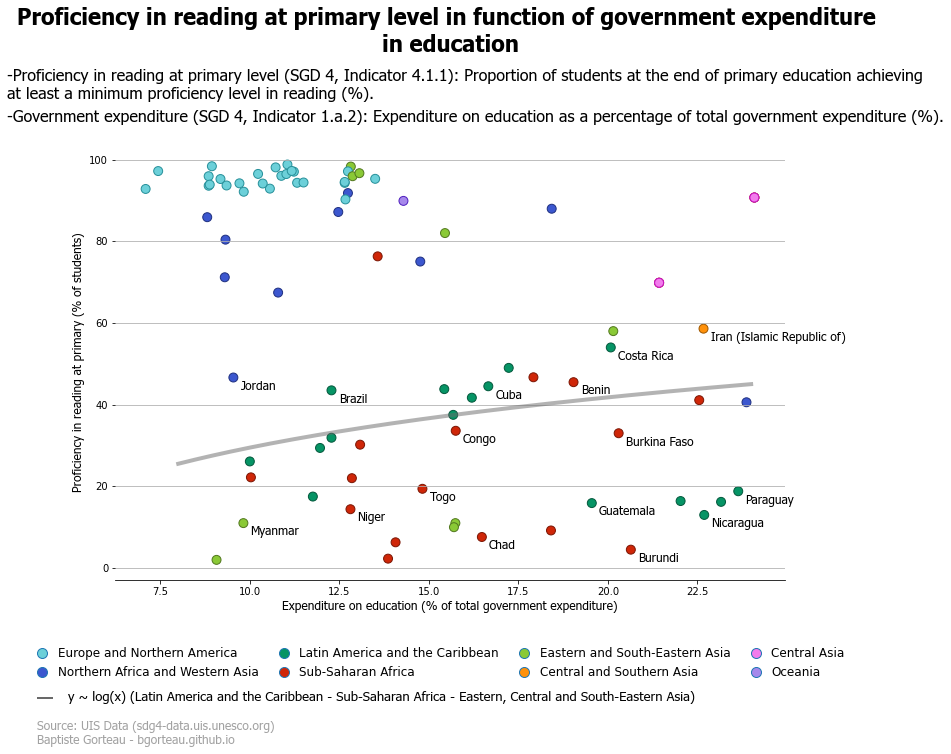

In [25]:
# Colors for each region

REGION_COLS = ["#f27cec", "#ff910a", "#8ac936", "#6cd0d9", "#069465", "#3c57cf", "#a688eb", "#cf2608"]

# Category values for the colors
CATEGORY_CODES = pd.Categorical(reading_expenditures_data["Region"]).codes

# Select colors for each region according to its category.
COLORS = np.array(REGION_COLS)[CATEGORY_CODES]

# Compute colors for the edges: simply darker versions of the original colors
EDGECOLORS = [adjust_lightness(color, 0.6) for color in COLORS]

# Plot the points

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(reading_expenditures_data["Governement_Expenditures"], reading_expenditures_data["Reading_Primary"],  color=COLORS, edgecolors=EDGECOLORS, s=80)

################# Linear Regression #################

# We only keep the relevant regions for the regression
data_linear_reg = reading_expenditures_data[reading_expenditures_data["Region"].isin(["SDG: Latin America and the Caribbean", "SDG: Sub-Saharan Africa", "SDG: Eastern and South-Eastern Asia", "SDG: Central Asia"])]

X = np.array(data_linear_reg["Governement_Expenditures"]).reshape(-1, 1)
y = list(data_linear_reg["Reading_Primary"])

# Initialize linear regression object
linear_regressor = LinearRegression()

# Fit linear regression model of reading at primary on the log of government expenditures in education
linear_regressor.fit(np.log(X), y)

# Make predictions
# * Construct a sequence of values ranging from 10 to 95 and
#   apply logarithmic transform to them.
x_pred = np.log(np.linspace(8, 24, num=200).reshape(-1, 1))

# * Use .predict() method with the created sequence
y_pred = linear_regressor.predict(x_pred)  

# Plot regression line.
# * Logarithmic transformation is reverted by using the exponential one.
ax.plot(np.exp(x_pred), y_pred, color="#696969", lw=4, alpha=0.5)

#####################################################

# Create a legend for the regions

REGIONS = {}
for region, index in zip(reading_expenditures_data["Region"], CATEGORY_CODES) :
    REGIONS[index] = region.split(": ")[1]

# Create handles for lines.
handles = [
    Line2D(
        [], [], label=label, 
        lw=0, # there's no line added, just the marker
        marker="o", # circle marker
        markersize=10, 
        markerfacecolor=REGION_COLS[idx], # marker fill color
    )
    for idx, label in zip(REGIONS.keys(), REGIONS.values())
]

legend = fig.legend(
    handles=handles,
    bbox_to_anchor=[0.5, -0.02], # Located in the top-mid of the figure.
    fontsize=12,
    handletextpad=0.6, # Space between text and marker/line
    handlelength=1.4, 
    columnspacing=1.4,
    loc="center", 
    ncol=4,
    frameon=False
)

#####################################################

# Add the names of a set countries

TEXTS = []

for x, y, country in zip(reading_expenditures_data["Governement_Expenditures"], reading_expenditures_data["Reading_Primary"], reading_expenditures_data["Country"]) :
    if country in ["Jordan", "Brazil", "Myanmar", "Niger", "Togo", "Chad", "Burundi", "Nicaragua", "Paraguay", "Guatemala", "Morroco", "Iran (Islamic Republic of)", "Costa Rica", 
                   "Burkina Faso", "Congo", "Benin", "Cuba"] :
        ax.text(x+0.2, y-3, country, fontsize=12, fontfamily="Tahoma")
    
#####################################################

# Add new elements to the figure 

ax.set_ylabel("Proficiency in reading at primary (% of students)", fontfamily="Tahoma", size=12)
ax.set_xlabel("Expenditure on education (% of total government expenditure)", fontfamily="Tahoma", size=12)
ax.set_title("Proficiency in reading at primary level in function of government expenditure \nin education", size=22, fontfamily="Tahoma", fontweight="bold", y=1.2)
ax.spines["left"].set_color("none")
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
ax.grid(axis="y")

fig.text(
    0, 0.96, "-Proficiency in reading at primary level (SGD 4, Indicator 4.1.1): Proportion of students at the end of primary education achieving \nat least a minimum proficiency level in reading (%).", 
    fontsize=16, fontfamily="Tahoma"
)
fig.text(
    0, 0.92, "-Government expenditure (SGD 4, Indicator 1.a.2): Expenditure on education as a percentage of total government expenditure (%).", 
    fontsize=16, fontfamily="Tahoma"
)
fig.text(
    0.035, -0.075, "__", 
    fontsize=16, fontweight="black", color="#696969"
)
fig.text(
    0.07, -0.085, "y ~ log(x) (Latin America and the Caribbean - Sub-Saharan Africa - Eastern, Central and South-Eastern Asia)", 
    fontsize=13, fontfamily="Tahoma"
)
fig.text(
    0.035, -0.16, "Source: UIS Data (sdg4-data.uis.unesco.org) \nBaptiste Gorteau - bgorteau.github.io", 
    fontsize=12, fontfamily="Tahoma", color="#a2a2a2"
)
fig.set_facecolor("white")
fig.savefig("figures/expenditure_reading.png", dpi=300, bbox_inches='tight', pad_inches=0.5)

# Primary schools with access to electricity

## Import the data and create a dataframe

### Proportion of primary schools with access to electricity

In [26]:
electricity_primary = pd.read_csv("data/electricity.csv")

Like for the representations before, we only keep the last record between 2018 and 2023 for each country.

In [27]:
new_electricity_primary = pd.DataFrame()

for country in pd.unique(electricity_primary["Country"]) :
    # Selecting the year of the last record
    last_year = max(list(electricity_primary[electricity_primary["Country"]==country]["Year"]))
    # Add the row of the last record to the new dataframe
    new_electricity_primary = pd.concat([new_electricity_primary, electricity_primary[(electricity_primary["Country"]==country)&(electricity_primary["Year"]==last_year)]])

In [28]:
new_electricity_primary

,Region,Country,Target,Indicator Number,Indicator Name,Year,Value,Metadata
0,SDG: Central and Southern Asia,Afghanistan,4.a,4.a.1,Proportion of primary schools with access to e...,2019,16.12,NaN
2,SDG: Latin America and the Caribbean,Anguilla,4.a,4.a.1,Proportion of primary schools with access to e...,2019,100.00,NaN
5,SDG: Europe and Northern America,Albania,4.a,4.a.1,Proportion of primary schools with access to e...,2021,100.00,NaN
11,SDG: Europe and Northern America,Andorra,4.a,4.a.1,Proportion of primary schools with access to e...,2022,100.00,NaN
13,SDG: Northern Africa and Western Asia,United Arab Emirates,4.a,4.a.1,Proportion of primary schools with access to e...,2020,100.00,NaN
...,...,...,...,...,...,...,...,...
508,SDG: Latin America and the Caribbean,British Virgin Islands,4.a,4.a.1,Proportion of primary schools with access to e...,2022,65.63,NaN
514,SDG: Eastern and South-Eastern Asia,Viet Nam,4.a,4.a.1,Proportion of primary schools with access to e...,2022,94.69,SOURCE: MOET (https://moet.gov.vn; MOET Stati...
519,SDG: Oceania,Samoa,4.a,4.a.1,Proportion of primary schools with access to e...,2022,100.00,SOURCE: UIS Dynamic Template with data from th...
521,SDG: Sub-Saharan Africa,Zambia,4.a,4.a.1,Proportion of primary schools with access to e...,2020,38.76,SOURCE: EDUCATIONAL STATISTICAL BULLETIN 2020...


### Mean of primary schools with access to electricity for every region

In [29]:
df_electricity_grouped = new_electricity_primary[["Region", "Value"]].groupby('Region').mean().reset_index().sort_values(by='Value', ascending=True)

In [30]:
df_electricity_grouped

,Region,Value
7,SDG: Sub-Saharan Africa,44.670938
1,SDG: Central and Southern Asia,80.115455
6,SDG: Oceania,88.272143
2,SDG: Eastern and South-Eastern Asia,92.707500
4,SDG: Latin America and the Caribbean,94.530000
5,SDG: Northern Africa and Western Asia,99.022778
3,SDG: Europe and Northern America,99.708333
0,SDG: Central Asia,99.890000


## Representaion

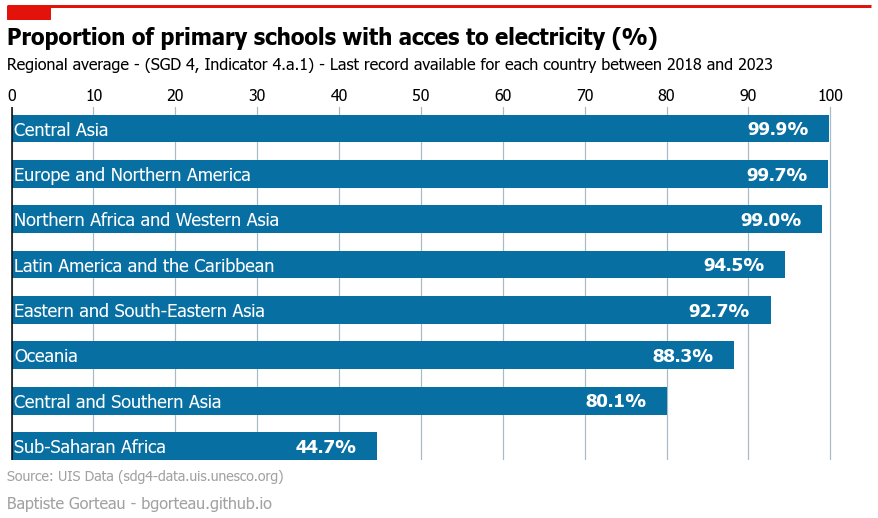

In [31]:
fig, ax = plt.subplots(figsize=(12, 7))

# Y values
y = [i * 0.9 for i in range(len(df_electricity_grouped))]

# Plot the bars
ax.barh(y, df_electricity_grouped["Value"], height=0.55, align="edge", color="#076fa2")
ax.xaxis.set_ticks([i * 10 for i in range(0, 11)])
ax.xaxis.set_ticklabels([i * 10 for i in range(0, 11)], size=16, fontfamily="Tahoma", fontweight=100)
ax.xaxis.set_tick_params(labelbottom=False, labeltop=True, length=0)

#########################################################

# Remove axis and background

ax.set_xlim((0, 105))
ax.set_ylim((0, len(df_electricity_grouped) * 0.9 - 0.2))

ax.set_axisbelow(True)
ax.grid(axis = "x", color="#A8BAC4", lw=1.2)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_lw(1.5)

ax.spines["left"].set_capstyle("butt")

ax.set_facecolor('none')

# Hide y labels
ax.yaxis.set_visible(False)

#########################################################

# Add region names and percentages on the figure

PAD = 0.3
for name, count, y_pos in zip(df_electricity_grouped["Region"], df_electricity_grouped["Value"], y):
    x = 0
    color = "white"
    path_effects = None
    if count < 40:
        x = count
        color = "#076fa2"   
        path_effects=[withStroke(linewidth=6, foreground="white")]
    
    ax.text(
        x + PAD, y_pos + 0.5 / 2, name.split(": ")[1], 
        color=color, fontfamily="Tahoma", fontsize=18, va="center",
        path_effects=path_effects
    )
    ax.text(
        count-10, y_pos + 0.5 / 2, "{}%".format(round(count,1)), 
        color=color, fontfamily="Tahoma", fontsize=18, va="center",
        path_effects=path_effects,
        fontweight="semibold"
    )
    

#########################################################

# Add other elements

# Make room on top and bottom
fig.subplots_adjust(left=0.005, right=1, top=0.8, bottom=0.1)

# Add title
fig.text(
    0, 0.925, "Proportion of primary schools with access to electricity (%)", 
    fontsize=22, fontweight="bold", fontfamily="Tahoma"
)
# Add subtitle
fig.text(
    0, 0.875, "Regional average - (SGD 4, Indicator 4.a.1) - Last record available for each country between 2018 and 2023", 
    fontsize=16, fontfamily="Tahoma"
)

# Add caption
source = "Source: UIS Data (sdg4-data.uis.unesco.org)"
fig.text(
    0, 0.06, source, color="#a2a2a2", 
    fontsize=14, fontfamily="Tahoma"
)

# Add authorship
fig.text(
    0, 0.005, "Baptiste Gorteau - bgorteau.github.io", color="#a2a2a2",
    fontsize=16, fontfamily="Tahoma"
)

# Add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color="#E3120B", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color="#E3120B"))

# Set facecolor, useful when saving as .png
fig.set_facecolor("white")

fig.savefig("figures/electricity_access.png", dpi=300, bbox_inches='tight', pad_inches=0.5)